# Identifying tweets related to customer service
Aim: automatically identify tweets related to customer care and transfer them to the managers of the customer service centers

# Table of Contents
1. [Data Preparation](#data-preparation)
    1. [Labeling training data](#Labeling-training-data)
2. [Building the model](#Building-the-model)
    1. [Keywords](#Keywords)
3. [Model Evaluation](#Model-Evaluation)

## Data Preparation

In [141]:
import pandas as pd

df = pd.read_csv("tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,name,retweet_count,text,tweet_created,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,cairdin,0,@TAA What @dhepburn said.,2/24/2015 11:35,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,jnardino,0,@TAA plus you've added commercials to the expe...,2/24/2015 11:15,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,yvonnalynn,0,@TAA I didn't today... Must mean I need to tak...,2/24/2015 11:15,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,jnardino,0,@TAA it's really aggressive to blast obnoxious...,2/24/2015 11:15,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,jnardino,0,@TAA and it's a really big bad thing about it,2/24/2015 11:14,Pacific Time (US & Canada)


### Labeling training data
0 -> NOT related to customer service

1 -> Related to customer service

In [142]:
import numpy as np
df['Is_Customer_Service_Issue'] = np.where(df['negativereason'] == 'Customer Service Issue', 1, 0)

df['text'][df['Is_Customer_Service_Issue']==1]

24       @TAA you guys messed up my seating.. I reserve...
25       @TAA status match program.  I applied and it's...
32       @TAA help, left expensive headphones on flight...
33       @TAA awaiting my return phone call, just would...
39       @TAA Your chat support is not working on your ...
                               ...                        
14620    @TAA I wait 2+ hrs for CS to call me back re w...
14621    @TAA I've been on hold for 55 mins about my Ca...
14629    @TAA How do I change my flight if the phone sy...
14636    @TAA leaving over 20 minutes Late Flight. No w...
14638    @TAA you have my money, you change my flight, ...
Name: text, Length: 2910, dtype: object

## Building the model

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#split into train set & test set
X = df['text']
y = df['Is_Customer_Service_Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# CountVectorizer will converts text to lowercase by default
binary_vectorizer = CountVectorizer(binary=True, stop_words={'english'})
binary_vectorizer.fit(X_train)
X_train_binary = binary_vectorizer.transform(X_train)
X_test_binary = binary_vectorizer.transform(X_test)

y_array_train = y_train.values.ravel()

In [144]:

from sklearn.linear_model import LogisticRegression

y_array_train = y_train.values.ravel()

#create logistic model
l_grid = {"C": [10**i for i in np.arange(-1, 2, 0.5)], "penalty": ['l1','l2']}
logistic_model = LogisticRegression(random_state=0, solver='liblinear', max_iter = 200)

# Search for best complexity when optimizing for AUC for logistic regression
from sklearn.model_selection import GridSearchCV
import numpy as np
l_searcher = GridSearchCV(logistic_model, l_grid, cv=3, scoring="roc_auc", verbose=1)
l_searcher.fit(X_train_binary, y_array_train)

# result
print(f"Best C for logsitic regression: {l_searcher.best_score_}")
print(f"Best params for logsitic regression: {l_searcher.best_params_}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best C for logsitic regression: 0.8713898215140926
Best params for logsitic regression: {'C': 0.1, 'penalty': 'l2'}


In [145]:
# Building the models
logistic_model = LogisticRegression(C= 0.1, penalty= 'l2', random_state=0, solver='saga', max_iter = 100000000)
logistic_model.fit(X_train_binary, y_array_train)

LogisticRegression(C=0.1, max_iter=100000000, random_state=0, solver='saga')

### Keywords 
Visualize keywords which are strongly correlated to customer service feedback

Red -> negatively correlated (less likely to be related to customer service issues)

Blue -> positively correlated (more likely to be related to customer service issues)

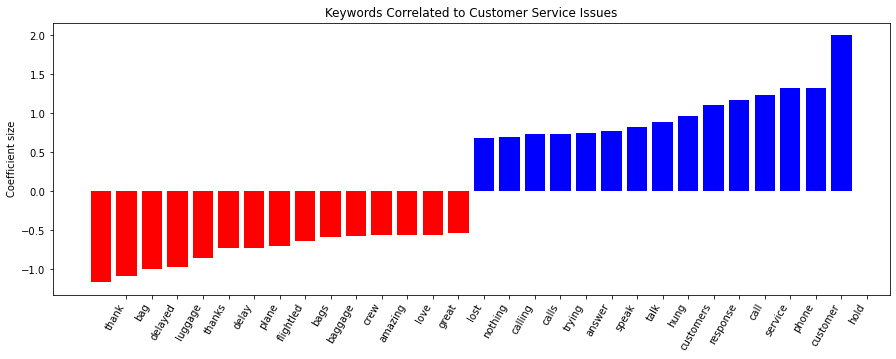

In [146]:
import matplotlib.pyplot as plt

def plot_coefficients(classifier, feature_names, num_features=15):
    coef = classifier.coef_.ravel() # Flatten coeffiecients
    top_positive_coefficients = np.argsort(coef)[-num_features:]
    top_negative_coefficients = np.argsort(coef)[:num_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * num_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * num_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.ylabel("Coefficient size")
    plt.title("Keywords Correlated to Customer Service Issues")
    plt.show()

feature_names = binary_vectorizer.get_feature_names_out()
plot_coefficients(logistic_model, feature_names)


## Model Evaluation

In [147]:
# Make predictions
model_predictions = logistic_model.predict(X_test_binary)
model_predictions

array([0, 0, 0, ..., 0, 0, 0])

In [148]:
# Accuracy
from sklearn.metrics import classification_report

print("Classification Report:","\n", classification_report(y_test, model_predictions))

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      2321
           1       0.80      0.46      0.58       607

    accuracy                           0.86      2928
   macro avg       0.83      0.72      0.75      2928
weighted avg       0.86      0.86      0.85      2928

